In [49]:
import pandas as pd
import os
import numpy as np
import logging
import sys
import torch
import copy
import yaml
import random

from prediction_utils.pytorch_utils.metrics import (
    StandardEvaluator,
    FairOVAEvaluator,
    CalibrationEvaluator
)

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style("ticks")


args = {'cohort_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts/cohort/all_cohorts.csv',
        'base_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts',
        'grp_label_dict': {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men', 'overall': 'Overall'},
        'plot_path': os.path.join('/labs/shahlab/projects/agataf/fairness_utility/eval_manuscript/plots', 'paper_plots'),

       }

output_path = os.path.join(args['plot_path'], 'risk_category_counts.png')
os.makedirs(args['plot_path'], exist_ok=True)


In [48]:
args['grp_label_dict']

KeyError: 'grp_label_dict'

In [47]:
args['grp_label_dict']

KeyError: 'grp_label_dict'

In [2]:
def get_frac_treated(df, add_strata=None):
    base_grouping = ['model_type', 'model_id','labels'] 
    if add_strata:
        base_grouping.append(add_strata)
    num_treated_by_stratum = (df
         .query('(phase=="test")')
         .filter(['person_id', 'treat'] + base_grouping)
         .groupby(['treat'] + base_grouping)
         .count()
        )

    num_per_stratum = (df
          .query('(phase=="test")')
               .filter(['person_id'] + base_grouping)
               .groupby(base_grouping)
               .count()
         )

    frac_treated = num_treated_by_stratum.div(num_per_stratum)


    return frac_treated.reset_index()

In [141]:
group_names = {'overall': 'overall',
               1: 'Black Women', 
               2: 'White Women', 
               3: 'Black Men', 
               4: 'White Men'
              }

model_type_names = {'original_pce': 'PCE',
                    'revised_pce': 'rPCE',
                    'erm': 'BL',
                    'recalib_erm': 'rBL',
                    'eqodds_thr': 'EO'
                   }

label_names = {0: ' Individuals with \nno ASCVD event', 1: 'Individuals with \n  ASCVD event'}

In [142]:
frac_treated_all = []
all_preds = []
eqodds_threshold = [0.1, 1]
for experiment in ['original_pce', 'revised_pce', 'apr14_erm', 'apr14_erm_recalib', 'apr14_thr']:

    aggregate_path = os.path.join(args['base_path'], 'experiments', 
                                      experiment, 'performance',
                                      'all')
    preds_path = os.path.join(aggregate_path, 'predictions.csv')
    preds = pd.read_csv(preds_path)
    
    if experiment in ['apr14_mmd', 'apr14_thr']:
        preds = preds.query('model_id == @eqodds_threshold')
        
    if 'model_id' not in preds.columns:
        preds = preds.assign(model_id=0)
    all_preds.append(preds)
    
all_preds = pd.concat(all_preds)
all_preds = all_preds.assign(group = lambda x: x.group.map(group_names),
                             model_type = lambda x: x.model_type.map(model_type_names),
                             labels = lambda x: x.labels.map(label_names))

model_type = np.where((all_preds.model_type=='EO') & (all_preds.model_id==0.1), 'mEO', all_preds.model_type)
model_type = np.where((all_preds.model_type=='EO') & (all_preds.model_id==1.0), 'sEO', model_type)


all_preds = all_preds.assign(model_type = pd.Categorical(model_type, 
                      categories=['PCE', 'rPCE', 'BL', 'rBL', 'mEO', 'sEO'],
                      ordered=True))


#     frac_treated = get_frac_treated(preds, add_strata='group') 
#     frac_treated_overall = get_frac_treated(preds, add_strata=None).assign(group='overall')
#     frac_treated = frac_treated.append(frac_treated_overall)
#     frac_treated = (frac_treated
#                     .assign(group = lambda x: x.group.map(args['grp_label_dict']),
#                             labels = lambda x: x.labels.map({0: ' Individuals with \nno ASCVD event',
#                                                              1: 'Individuals with \n  ASCVD event'}))
#                     .rename(columns={'person_id': 'fraction'})
#                    )
#     frac_treated_all.append(frac_treated)

# frac_treated_all = (pd
#                     .concat(frac_treated_all)
#                     .assign(model_type = lambda x: x.model_type.map({'original_pce': 'PCE',
#                                                                      'revised_pce': 'rPCE',
#                                                                      'erm': 'BL',
#                                                                      'recalib_erm': 'rBL',
#                                                                      'eqodds_thr': 'EO',
#                                                                     }
#                                                                    )
#                            )
#                    )



# model_type = np.where((frac_treated_all.model_type=='EO') & (frac_treated_all.model_id==0.1), 'mEO', frac_treated_all.model_type)
# model_type = np.where((frac_treated_all.model_type=='EO') & (frac_treated_all.model_id==1.0), 'sEO', model_type)

# frac_treated_all = frac_treated_all.assign(model_type=model_type)


<Figure size 432x288 with 0 Axes>

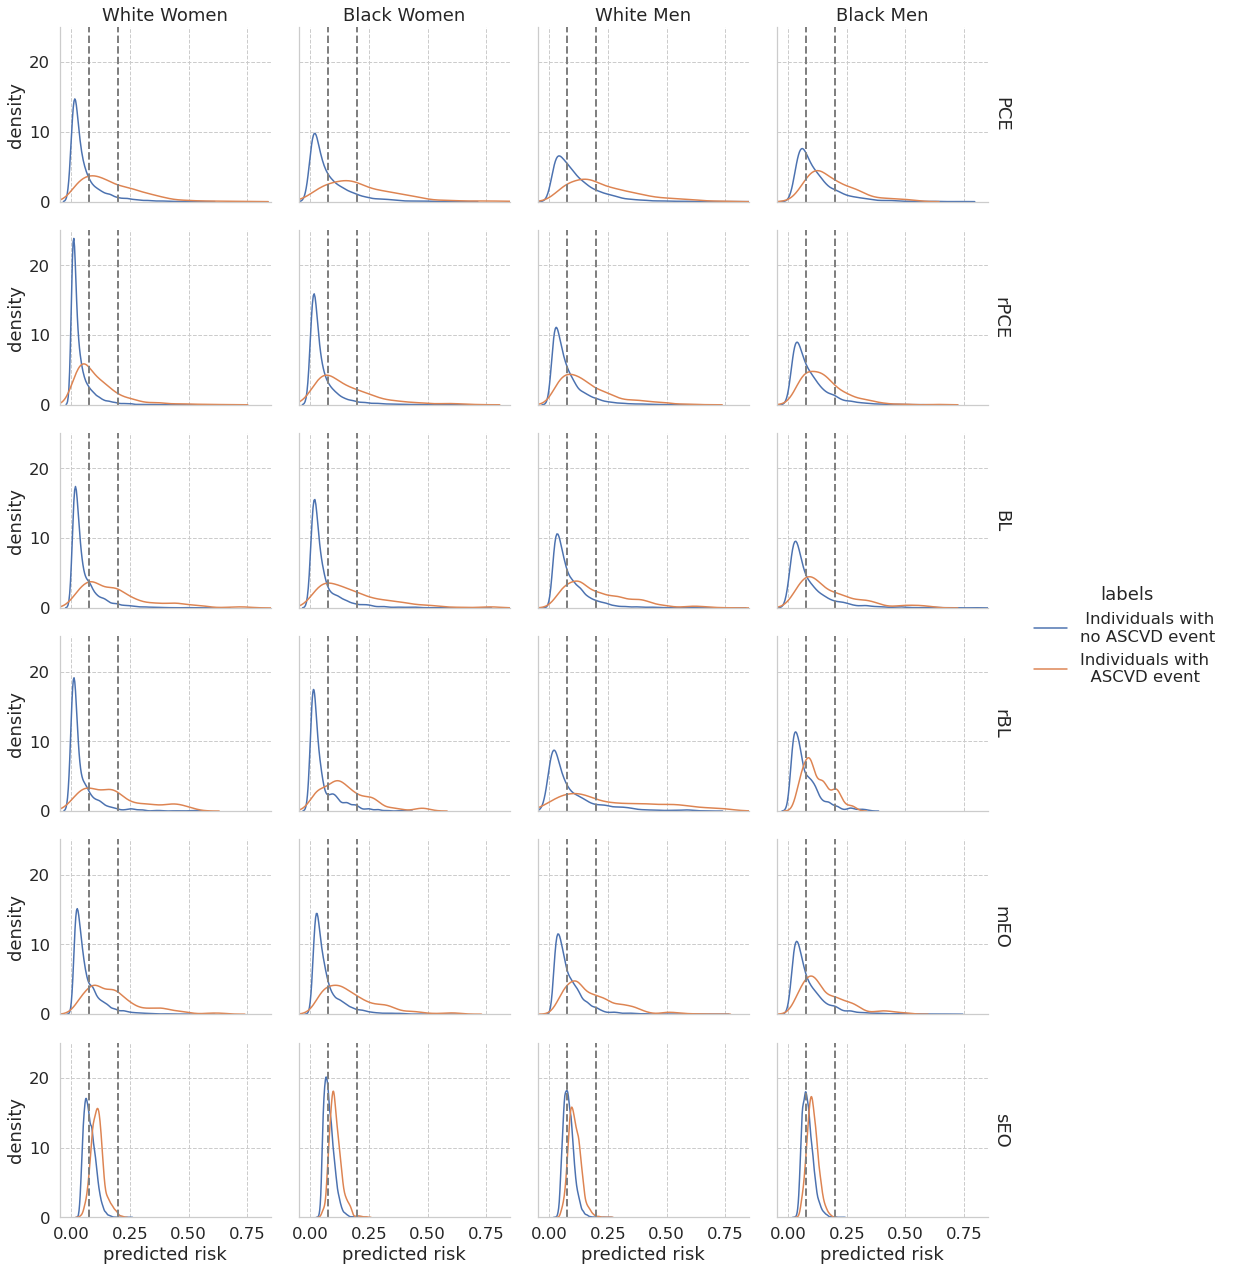

In [148]:
sns.despine(left=True)

sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.FacetGrid(all_preds, 
                  col="group", 
                  row = "model_type",
                  hue='labels',
                  height=3, aspect=1.2,
                 margin_titles=True)
g.map(sns.kdeplot, 
      "pred_probs",
     # weights="weights"
     )

(g.set_xlabels('predicted risk')
 .set_ylabels('density')
 .set_titles(row_template="{row_name}", col_template="{col_name}")
 #.set_yticklabels()
)
g.add_legend()
g.set(xlim=(-0.05, 0.85))
axes = g.axes.flatten()
for ax in axes:
    ax.axvline(0.075, ls='--', linewidth=2, color='grey')
    ax.axvline(0.2, ls='--', linewidth=2, color='grey')